## Indice de Construction Normalisé (NDBI)

### Description de l’indicateur

Le **NDBI (Normalized Difference Built-up Index)** est un indice spectral
utilisé en télédétection pour **identifier et cartographier les zones
bâties ou artificialisées** à la surface terrestre. Il permet de différencier
les zones urbaines des zones végétalisées ou aquatiques.

Le principe du NDBI repose sur la **différence spectrale entre le proche
infrarouge (NIR) et les bandes du moyen infrarouge (SWIR)**. Les surfaces
bâties et artificialisées réfléchissent davantage le rayonnement dans le
**SWIR** que dans le **NIR**, tandis que la végétation et l’eau présentent
des comportements inverses.

Les valeurs du NDBI sont comprises entre **−1 et +1** :

- **NDBI négatif** : zones non bâties, principalement végétation dense ou
  plans d’eau ;
- **NDBI proche de 0** : zones mixtes, transition entre zones bâties et
  naturelles ;
- **NDBI positif (> 0)** : zones fortement urbanisées ou surfaces artificialisées.

Le NDBI est particulièrement utilisé pour :
- la cartographie et le suivi de l’urbanisation ;
- l’analyse de la densité des constructions ;
- l’évaluation de l’extension des villes et la planification
  urbaine ;
- les études environnementales sur l’artificialisation du sol.

---

### Méthodologie de calcul

Le NDBI est calculé à partir des images multispectrales du satellite
**Sentinel-2**, avec une combinaison spécifique de bandes :

- **B8 (Proche infrarouge – NIR)** : bande centrée autour de **842 nm**, fortement
  réfléchie par la végétation ;
- **B11 (Moyen infrarouge – SWIR)** : bande centrée autour de **1610 nm**, sensible
  aux matériaux urbains et aux surfaces artificialisées.

La formule du NDBI est définie comme suit :

$$
NDBI = \frac{SWIR - NIR}{SWIR + NIR}
$$

où :
- $SWIR$ représente la réflectance de la bande **B11** ;
- $NIR$ représente la réflectance de la bande **B8**.

La normalisation permet d’obtenir un indicateur **adimensionnel**, borné
entre −1 et +1, et de comparer les zones urbanisées dans l’espace et le temps.

---



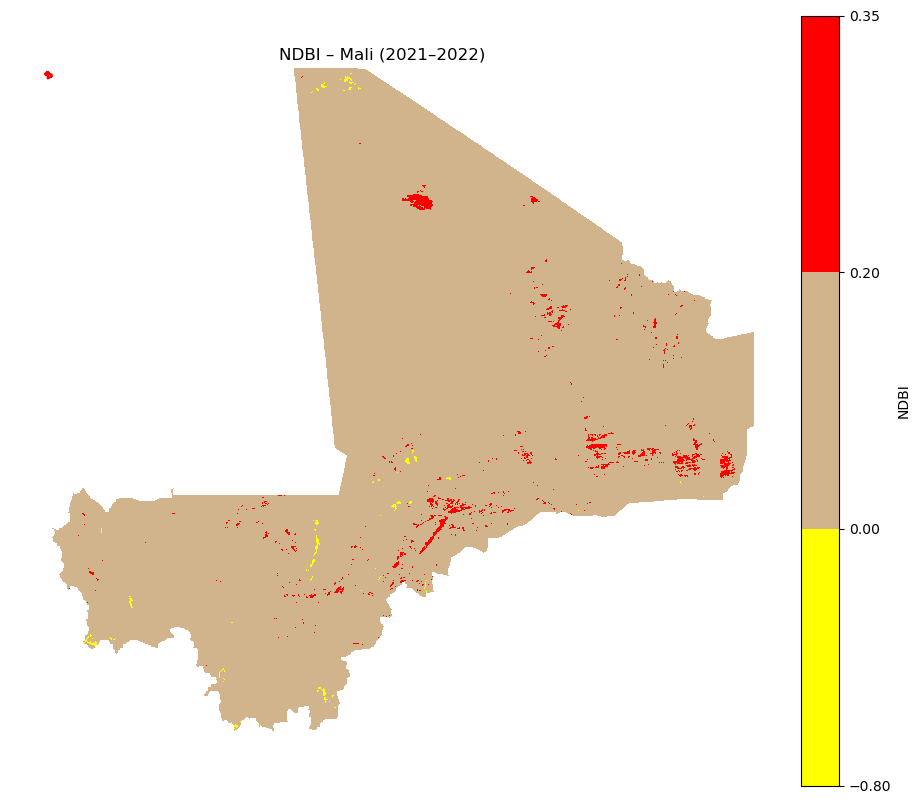

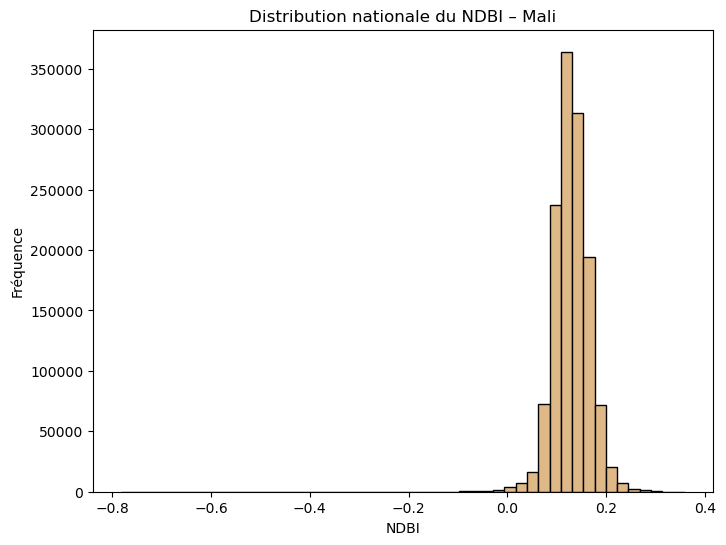

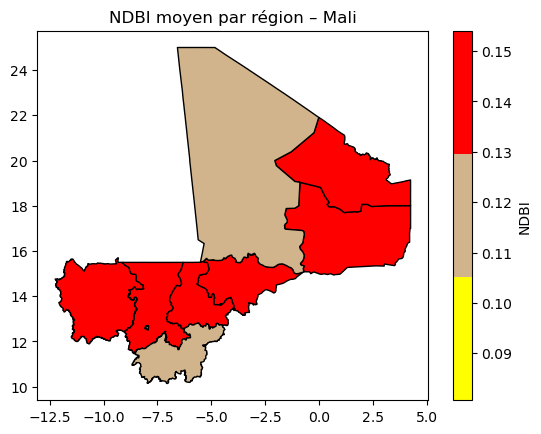

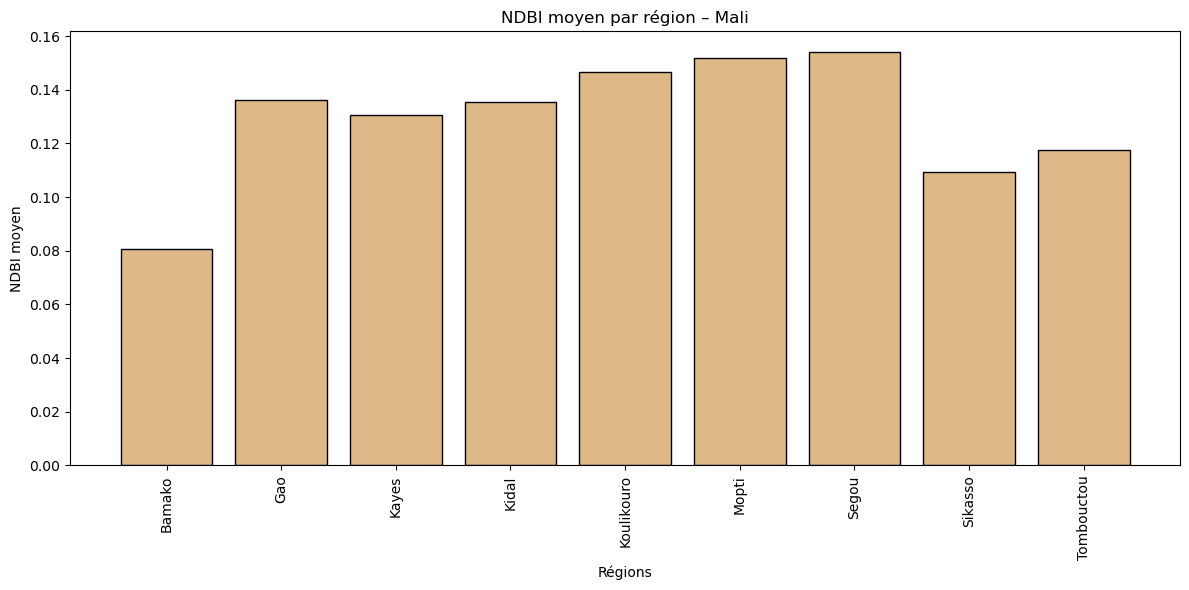

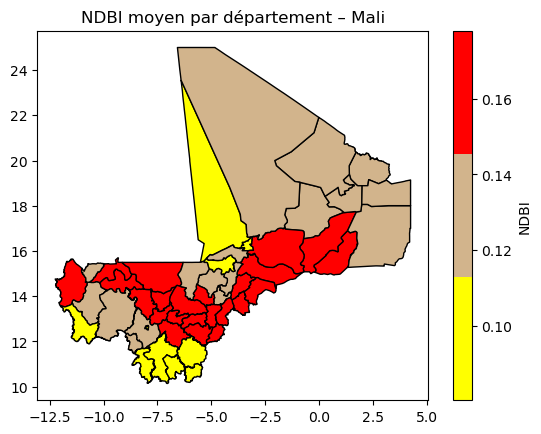

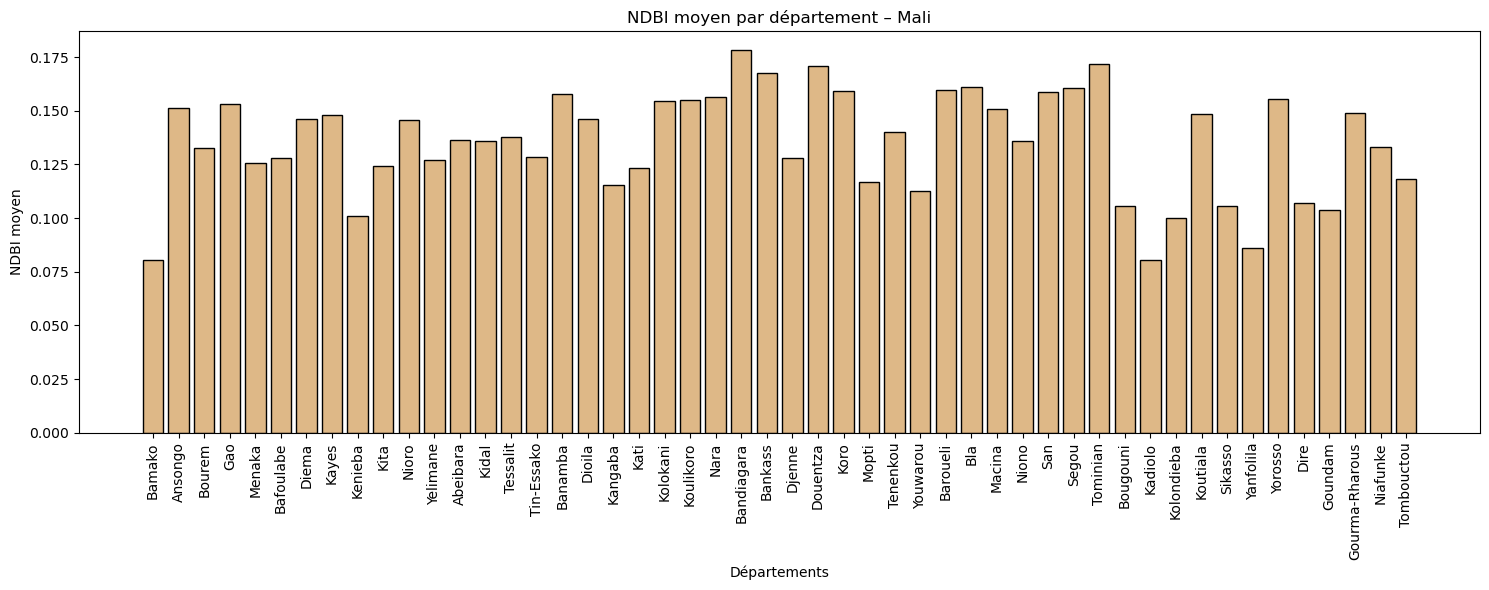

Table départementale NDBI enregistrée dans outputs/NDBI/


In [2]:
# ======================================================
# NDBI.ipynb – Calcul et analyse exploratoire du NDBI
# Résolution rééchantillonnée : 1 km pour éviter MemoryError
# ======================================================

import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.mask import mask
from rasterio.enums import Resampling
from matplotlib.colors import ListedColormap, BoundaryNorm

# 1️⃣ Chemins
BASE_DIR = os.getcwd()  # tp/scripts
DATA_DIR = os.path.join(BASE_DIR, "..", "data")
OUTPUT_DIR = os.path.join(BASE_DIR, "..", "outputs", "NDBI")
os.makedirs(OUTPUT_DIR, exist_ok=True)

path_nir = os.path.join(DATA_DIR, "Mali_2022_B8_100m.tif")   # NIR
path_swir = os.path.join(DATA_DIR, "Mali_2022_B11_100m.tif") # SWIR

# 2️⃣ Lecture et rééchantillonnage à 1 km
with rasterio.open(path_nir) as src:
    new_width = src.width // 10
    new_height = src.height // 10
    nir = src.read(
        1,
        out_shape=(new_height, new_width),
        resampling=Resampling.average
    ).astype("float32")
    profile = src.profile.copy()
    profile.update({
        "height": new_height,
        "width": new_width,
        "transform": src.transform * src.transform.scale(
            (src.width / new_width),
            (src.height / new_height)
        )
    })

with rasterio.open(path_swir) as src:
    swir = src.read(
        1,
        out_shape=(new_height, new_width),
        resampling=Resampling.average
    ).astype("float32")

# 3️⃣ Calcul NDBI
np.seterr(divide='ignore', invalid='ignore')
ndbi = (swir - nir) / (swir + nir)
ndbi = np.where((ndbi < -1) | (ndbi > 1), np.nan, ndbi)

# 4️⃣ Palette NDBI : urbain = brun, basse = jaune, végétation = vert
ndbi_bounds = [-0.8, 0, 0.2, 0.35]  
ndbi_colors = ["#FFFF00", "#D2B48C", "#FF0000"]  # jaune, marron clair, rouge
cmap = ListedColormap(ndbi_colors)
norm = BoundaryNorm(ndbi_bounds, ncolors=cmap.N)


# 5️⃣ Carte nationale NDBI
mali_shape = gpd.read_file(os.path.join(DATA_DIR, "mli_admin0.shp"))
mali_shape = mali_shape.to_crs(profile['crs'])

plt.figure(figsize=(12, 10))
plt.imshow(ndbi, cmap=cmap, norm=norm)
mali_shape.boundary.plot(edgecolor="red", linewidth=1.5, ax=plt.gca())
plt.colorbar(label="NDBI")
plt.title("NDBI – Mali (2021–2022)")
plt.axis("off")
plt.savefig(os.path.join(OUTPUT_DIR, "NDBI_nationale.png"), dpi=300)
plt.show()

# Histogramme national
plt.figure(figsize=(8, 6))
plt.hist(ndbi[~np.isnan(ndbi)], bins=50, color="#deb887", edgecolor="black")
plt.title("Distribution nationale du NDBI – Mali")
plt.xlabel("NDBI")
plt.ylabel("Fréquence")
plt.savefig(os.path.join(OUTPUT_DIR, "NDBI_histogramme_nationale.png"), dpi=300)
plt.show()

# 6️⃣ Analyse régionale (Admin1)
gadm1 = gpd.read_file(os.path.join(DATA_DIR, "mli_admin1.shp"))
gadm1 = gadm1.to_crs(profile['crs'])
regional_ndbi = []

for idx, row in gadm1.iterrows():
    geom = [row['geometry']]
    with rasterio.open(path_nir) as src:
        nir_clip, _ = mask(src, geom, crop=True)
    with rasterio.open(path_swir) as src:
        swir_clip, _ = mask(src, geom, crop=True)
    nir_clip = nir_clip[0].astype("float32")
    swir_clip = swir_clip[0].astype("float32")
    ndbi_clip = (swir_clip - nir_clip) / (swir_clip + nir_clip)
    ndbi_clip = np.where((ndbi_clip < -1) | (ndbi_clip > 1), np.nan, ndbi_clip)
    regional_ndbi.append(np.nanmean(ndbi_clip))

gadm1['NDBI'] = regional_ndbi

# Carte régionale
gadm1.plot(column='NDBI', cmap=cmap, edgecolor='black', legend=True,
           legend_kwds={'label': "NDBI", 'orientation': "vertical"})
plt.title("NDBI moyen par région – Mali")
plt.savefig(os.path.join(OUTPUT_DIR, "NDBI_regionale.png"), dpi=300)
plt.show()

# Bar plot régional inversé
plt.figure(figsize=(12, 6))
plt.bar(gadm1['shapeName'], gadm1['NDBI'], color="#deb887", edgecolor="black")
plt.xticks(rotation=90)
plt.title("NDBI moyen par région – Mali")
plt.xlabel("Régions")
plt.ylabel("NDBI moyen")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "NDBI_bar_region.png"), dpi=300)
plt.show()

# 7️⃣ Analyse départementale (Admin2)
gadm2 = gpd.read_file(os.path.join(DATA_DIR, "mli_admin2.shp"))
gadm2 = gadm2.to_crs(profile['crs'])
dept_ndbi = []

for idx, row in gadm2.iterrows():
    geom = [row['geometry']]
    with rasterio.open(path_nir) as src:
        nir_clip, _ = mask(src, geom, crop=True)
    with rasterio.open(path_swir) as src:
        swir_clip, _ = mask(src, geom, crop=True)
    nir_clip = nir_clip[0].astype("float32")
    swir_clip = swir_clip[0].astype("float32")
    ndbi_clip = (swir_clip - nir_clip) / (swir_clip + nir_clip)
    ndbi_clip = np.where((ndbi_clip < -1) | (ndbi_clip > 1), np.nan, ndbi_clip)
    dept_ndbi.append(np.nanmean(ndbi_clip))

gadm2['NDBI'] = dept_ndbi

# Carte départementale
gadm2.plot(column='NDBI', cmap=cmap, edgecolor='black', legend=True,
           legend_kwds={'label': "NDBI", 'orientation': "vertical"})
plt.title("NDBI moyen par département – Mali")
plt.savefig(os.path.join(OUTPUT_DIR, "NDBI_departementale.png"), dpi=300)
plt.show()

# Bar plot départemental inversé
plt.figure(figsize=(15, 6))
plt.bar(gadm2['shapeName'], gadm2['NDBI'], color="#deb887", edgecolor="black")
plt.xticks(rotation=90)
plt.title("NDBI moyen par département – Mali")
plt.xlabel("Départements")
plt.ylabel("NDBI moyen")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "NDBI_bar_departements.png"), dpi=300)
plt.show()

# Enregistrer la table départementale NDBI
ndbi_table = gadm2[['shapeName', 'NDBI']].copy()
ndbi_table.to_csv(os.path.join(OUTPUT_DIR, "NDBI_departements.csv"), index=False)
print("Table départementale NDBI enregistrée dans outputs/NDBI/")
